In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
from ccbo.core import (
    sim_espray_constrained,
    optimize_acqf_and_get_recommendation,
)

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cpu"),
}

# Set the aiming particle size (um)
TARGET_SIZE = torch.tensor(6.0, **tkwargs)

# Set the solvent dictionary: 0 for DMAc, 1 for CHCl3
SOLVENT_DICT = {1: "CHCl3", 0: "DMAc"}

# Set the bounds for the processing parameters: Concentration (%), Flow Rates (uL/min), Voltage (kV), Solvent
bounds = torch.tensor([[0.05, 0.01, 10, 0], [5.0, 60.0, 18, 1]], **tkwargs)

# Set params for benchmark
ITERS = 10
TRIALS = 20
BATCH_SIZE = 2
strategies = ("qEI", "qEI_vi_mixed_con", "qEICF_vi_mixed_con", "rnd") # qEI for vanilla BO, qEI_vi_mixed_con for constrained BO, qEICF_vi_mixed_con for CCBO, rnd for random search

# Set if using parallel computing
PARA_EVAL = True

# exp_record organized by [Concentration (%), Flow Rate (uL/min), Voltage (kV), Solvent]
exp_record = torch.tensor(
    [
        [0.5, 15, 10, 0],
        [0.5, 0.1, 10, 1],
        [3, 20, 15, 0],
        [1, 20, 10, 1],
        [0.2, 0.02, 10, 1],
    ],
    **tkwargs
)

X_init = exp_record
Y_init = sim_espray_constrained(X_init)

# show initial experiment as a dataframe
experiment_df = pd.DataFrame(
    torch.cat([X_init, Y_init], dim=-1).detach().numpy(),
    columns=["Concentration (%)", "Flow Rate (uL/min)", "Voltage (kV)", "Solvent", "Particle Size (um)", "Feasibility"],
)
# Convert the solvent column to string
experiment_df["Solvent"] = experiment_df["Solvent"].map({1: "CHCl3", 0: "DMAc"})
experiment_df

,Concentration (%),Flow Rate (uL/min),Voltage (kV),Solvent,Particle Size (um),Feasibility
0,0.5,15.00,10.0,0.0,8.644046,1.0
1,0.5,0.10,10.0,1.0,2.073124,1.0
2,3.0,20.00,15.0,0.0,20.226423,0.0
3,1.0,20.00,10.0,1.0,14.862471,1.0
4,0.2,0.02,10.0,1.0,1.590388,0.0


# Benchmark

In [8]:
def perform_trial(trial):
    # Set the random seed for reproducibility
    torch.manual_seed(trial)
    print("Trial:", trial)
    # Initialize the X and Y for each strategy
    X_bo = {k: X_init.clone() for k in strategies}
    Y_bo = {k: Y_init.clone() for k in strategies}

    # Initialize the result dictionary, best distance and raw_Y, for each strategy
    best_distance = {k: None for k in strategies}

    for strategy in strategies:
        print(f"Performing Bayesian optimization using {strategy}...")
        best_distance_strategy = np.zeros(ITERS + 1)

        for iter in range(ITERS + 1):
            print("Iteration:", iter)
            # record the best distance and raw_Y at this iteration
            Y_distance = -np.abs(Y_bo[strategy][:, 0] - TARGET_SIZE)
            best_distance_strategy[iter] = Y_distance.max().numpy()

            # perform the optimization and recommend next experiments
            new_x = optimize_acqf_and_get_recommendation(
                X_bo[strategy],
                Y_bo[strategy],
                bounds,
                y_target=TARGET_SIZE,
                strategy=strategy,
                batch_size=BATCH_SIZE,
            )

            X_bo[strategy] = torch.cat([X_bo[strategy], new_x])
            Y_bo[strategy] = torch.cat([Y_bo[strategy], sim_espray_constrained(new_x)])

        # log the best distances for this strategy over all iterations
        best_distance[strategy] = best_distance_strategy

    return best_distance, {"X": X_bo, "Y": Y_bo}

#perform the trials
if PARA_EVAL:
    results = Parallel(n_jobs=-1, verbose=80)(
        delayed(perform_trial)(trial) for trial in range(TRIALS)
    )
else:
    results = [perform_trial(trial) for trial in range(TRIALS)]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 34.8min
[Parallel(n_jobs=-1)]: Done   2 out of  20 | elapsed: 36.3min remaining: 327.0min
[Parallel(n_jobs=-1)]: Done   3 out of  20 | elapsed: 36.6min remaining: 207.2min
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed: 38.1min remaining: 152.2min
[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed: 39.7min remaining: 119.1min
[Parallel(n_jobs=-1)]: Done   6 out of  20 | elapsed: 40.3min remaining: 94.0min
[Parallel(n_jobs=-1)]: Done   7 out of  20 | elapsed: 42.1min remaining: 78.2min
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed: 42.2min remaining: 63.3min
[Parallel(n_jobs=-1)]: Done   9 out of  20 | elapsed: 42.5min remaining: 52.0min
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed: 43.3min remaining: 43.3min
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed: 45.0min remaining: 36.8min
[Parallel(n_jobs=-1)]: Done  12 out of  20 | el

# Data post-processing

In [9]:
#unpack the results
best_distances = {k: [] for k in strategies}
best_raw_Ys = {k: [] for k in strategies}
for result in results:
    best_distance, _ = result
    for strategy in strategies:
        best_distances[strategy].append(best_distance[strategy])

# vstack all values in best_distances
best_distances_vstack = {
    k: np.vstack(
        best_distances[k],
    )
    for k in strategies
}
best_distances_all_trials = -np.vstack([best_distances_vstack[k] for k in strategies])
best_distances_all_trials_df = pd.DataFrame(best_distances_all_trials)

# add strategy and trial columns
best_distances_all_trials_df["strategy"] = np.repeat(
    ["Vanilla BO", "Constrained BO", "CCBO", "rnd"], TRIALS
)
best_distances_all_trials_df["trial"] = list(range(TRIALS)) * len(strategies)

# conver into long format('qEI','qEI_vi_mixed_con','qEICF_vi_mixed_con','rnd')
best_distances_df_long = pd.melt(
    best_distances_all_trials_df,
    id_vars=["strategy", "trial"],
    var_name="iteration",
    value_name="regret",
)

# Plotting

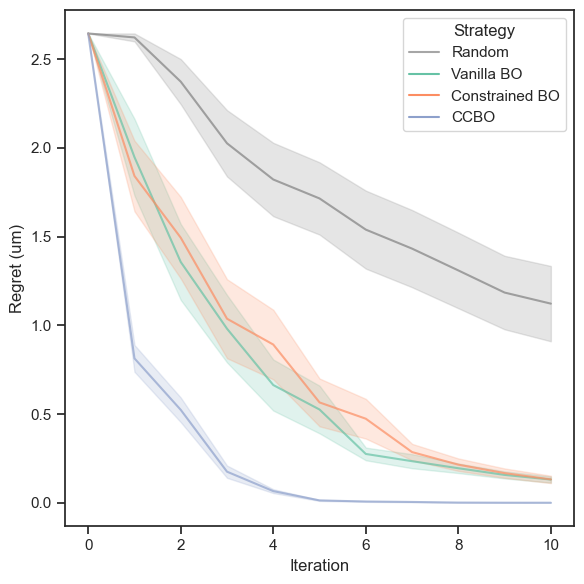

In [10]:
# plot the results with error bars from multiple trials using seaborn
sns.set_theme(style="ticks", palette="Set2")
# plot the results
fig = plt.figure(figsize=(6,6))

rnd_best_distances = best_distances_df_long[best_distances_df_long['strategy'] == 'rnd']
bo_best_distances = best_distances_df_long[best_distances_df_long['strategy'] != 'rnd']

# plot strategy==rnd as gray
sns.lineplot(
    data=rnd_best_distances,
    x="iteration",
    y="regret",
    color="gray",
    errorbar="se",
    alpha=0.7,
    label="Random",
)

sns.lineplot(
    data=bo_best_distances,
    x="iteration",
    y="regret",
    hue="strategy",
    errorbar="se",
    alpha=0.7,
)

# set labels
plt.xlabel("Iteration")
plt.ylabel("Regret (um)")
plt.legend(title="Strategy")

plt.tight_layout()
#plt.savefig(f"ccbo_benchmark_{TARGET_SIZE}um.png", dpi=300)
plt.show()